In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/tweets//

/content/drive/MyDrive/tweets


In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [259]:
data = pd.read_csv('tweets.csv')

In [5]:
data.head(5)

,tweet_id,airline,name,text,tweet_coord,tweet_created,tweet_location,user_timezone,sentiment
0,567588000000000000,Delta,JetBlueNews,@JetBlue's new CEO seeks the right balance to ...,NaN,16-02-15 23:36,USA,Sydney,NEUTRAL
1,567590000000000000,Delta,nesi_1992,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,NaN,16-02-15 23:43,undecided,Pacific Time (US & Canada),NEGATIVE
2,567591000000000000,United,CPoutloud,@united yes. We waited in line for almost an h...,NaN,16-02-15 23:48,"Washington, DC",NaN,NEUTRAL
3,567592000000000000,United,brenduch,@united the we got into the gate at IAH on tim...,NaN,16-02-15 23:52,NaN,Buenos Aires,NEUTRAL
4,567594000000000000,Southwest,VahidESQ,@SouthwestAir its cool that my bags take a bit...,NaN,17-02-15 0:00,"Los Angeles, CA",Pacific Time (US & Canada),POSITIVE


In [260]:
len(data)

14640

In [261]:
data.nunique()

tweet_id           2434
airline               6
name               7701
text              14427
tweet_coord         832
tweet_created      6804
tweet_location     2989
user_timezone        85
sentiment             4
dtype: int64

In [262]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        14640 non-null  int64 
 1   airline         14640 non-null  object
 2   name            14640 non-null  object
 3   text            14640 non-null  object
 4   tweet_coord     1019 non-null   object
 5   tweet_created   14640 non-null  object
 6   tweet_location  9907 non-null   object
 7   user_timezone   9820 non-null   object
 8   sentiment       14640 non-null  object
dtypes: int64(1), object(8)
memory usage: 1.0+ MB


In [263]:
data.isna().sum()

tweet_id              0
airline               0
name                  0
text                  0
tweet_coord       13621
tweet_created         0
tweet_location     4733
user_timezone      4820
sentiment             0
dtype: int64

In [264]:
data.duplicated().sum()

155

In [265]:
len(data)

14640

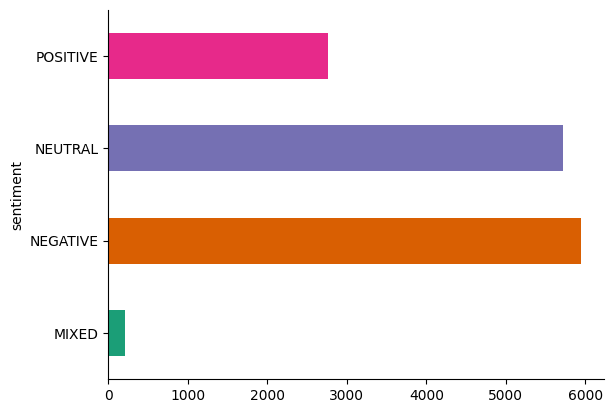

In [266]:
data.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

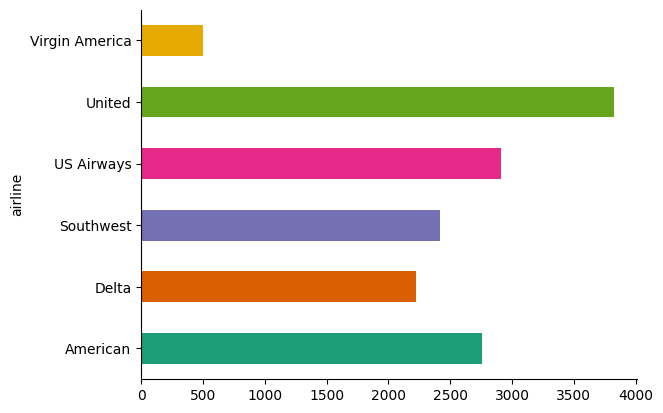

In [267]:
data.groupby('airline').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

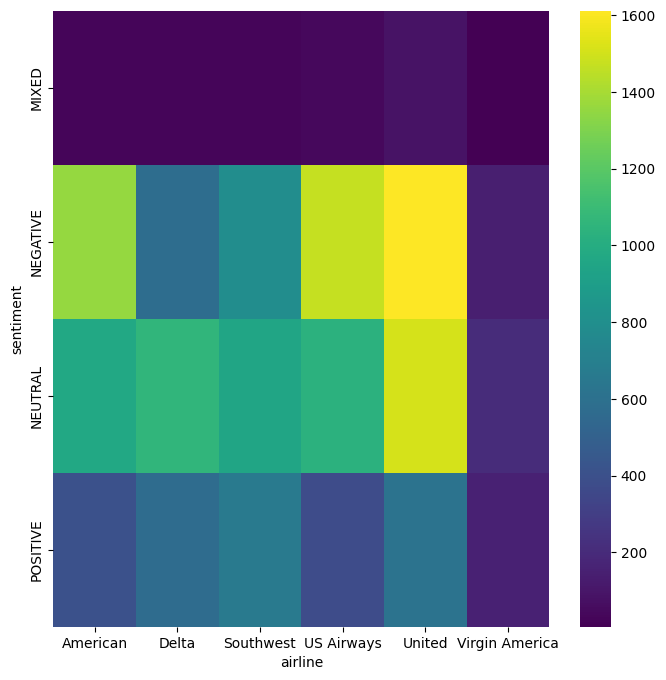

In [268]:
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['sentiment'].value_counts()
    for x_label, grp in data.groupby('airline')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('airline')
_ = plt.ylabel('sentiment')


In [45]:
data['sentiment'] = data['sentiment'].replace('MIXED', 'NEUTRAL')


In [269]:
data = data.drop_duplicates()

In [270]:
data = data.drop(['tweet_coord', 'tweet_id', 'name', 'tweet_created',	'tweet_location',	'user_timezone','airline'], axis = 1)

In [271]:
data = data.dropna()

In [272]:
data

,text,sentiment
0,@JetBlue's new CEO seeks the right balance to ...,NEUTRAL
1,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,NEGATIVE
2,@united yes. We waited in line for almost an h...,NEUTRAL
3,@united the we got into the gate at IAH on tim...,NEUTRAL
4,@SouthwestAir its cool that my bags take a bit...,POSITIVE
...,...,...
14635,@JetBlue I hope so because I fly very often an...,NEGATIVE
14636,@USAirways is a DM possible if you aren't foll...,NEUTRAL
14637,@JetBlue Yesterday on my way from EWR to FLL j...,NEUTRAL
14638,@USAirways and when will one of these agents b...,NEUTRAL


In [273]:
import numpy as np
import pandas as pd
import string
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense
import nltk
from nltk.corpus import stopwords
import contractions
import spacy
from bs4 import BeautifulSoup
import string
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re

In [274]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

data['text'] = data['text'].apply(remove_punctuation)

In [275]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stop_words(text):
    return ' '.join(word for word in text.split() if word.lower() not in stop_words)

data['text'] = data['text'].apply(remove_stop_words)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [276]:
def remove_emoji(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

data['text'] = data['text'].apply(remove_emoji)


In [277]:
def expand_contractions(text):
    return contractions.fix(text)

data['text'] = data['text'].apply(expand_contractions)

In [278]:
nlp = spacy.load("en_core_web_sm")

def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join(token.lemma_ for token in doc if token.lemma_ != '-PRON-')


data['text'] = data['text'].apply(lemmatize_text)

In [279]:
nltk.download('punkt')
nltk.download('wordnet')

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def normalize_text(text):
    tokens = nltk.word_tokenize(text.lower())

    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    stemmed_tokens = [stemmer.stem(token) for token in lemmatized_tokens]

    return ' '.join(stemmed_tokens)

data['text'] = data['text'].apply(normalize_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [280]:
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

data['text'] = data['text'].apply(remove_numbers)

In [281]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['text'])

sequences = tokenizer.texts_to_sequences(data['text'])

data['text'] = data['text'].apply(lambda x: ' '.join(tokenizer.sequences_to_texts(tokenizer.texts_to_sequences([x]))))

data['text'] = [tokenizer.sequences_to_texts([seq])[0].split() for seq in sequences]

In [283]:
data['text']

0        [jetblu, new, ceo, seek, right, balanc, pleas,...
1                    [jetblu, realli, get, nerv, nothappi]
2        [unit, ye, wait, line, almost, hour, passeng, ...
3        [unit, get, gate, iah, time, give, seat, close...
4        [southwestair, cool, bag, take, bit, long, do,...
                               ...                        
14635    [jetblu, hope, fli, often, would, hate, chang,...
14636             [usairway, dm, possibl, be, not, follow]
14637    [jetblu, yesterday, way, ewr, fll, takeoff, wh...
14638                 [usairway, one, agent, avail, speak]
14639    [usairway, well, time, call, flight, friday, n...
Name: text, Length: 14485, dtype: object

In [286]:
data

,text,sentiment
0,"[jetblu, new, ceo, seek, right, balanc, pleas,...",NEUTRAL
1,"[jetblu, realli, get, nerv, nothappi]",NEGATIVE
2,"[unit, ye, wait, line, almost, hour, passeng, ...",NEUTRAL
3,"[unit, get, gate, iah, time, give, seat, close...",NEUTRAL
4,"[southwestair, cool, bag, take, bit, long, do,...",POSITIVE
...,...,...
14635,"[jetblu, hope, fli, often, would, hate, chang,...",NEGATIVE
14636,"[usairway, dm, possibl, be, not, follow]",NEUTRAL
14637,"[jetblu, yesterday, way, ewr, fll, takeoff, wh...",NEUTRAL
14638,"[usairway, one, agent, avail, speak]",NEUTRAL


In [127]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


In [316]:
x = data['text']
y = data['sentiment']

tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(x)
text_sequences = tokenizer.texts_to_sequences(x)
x = pad_sequences(text_sequences, maxlen=100)


In [317]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [318]:
if len(x) == len(y):
    x_smote, y_smote = SMOTE().fit_resample(x, y)
else:
    print("mismatch lenght of x and y")

In [319]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBRFClassifier, XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [320]:
def model(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

    models = {
        'AdaBoostClassifier': AdaBoostClassifier(random_state=42),
        'HistGradientBoostingClassifier': HistGradientBoostingClassifier(random_state=42),
        'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42),
        'RandomForestClassifier': RandomForestClassifier(random_state=42),
        'XGBClassifier': XGBClassifier(random_state=42),
        'XGBRFClassifier': XGBRFClassifier(random_state=42)
    }

    results = {}

    for model_name, model in models.items():
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        cm = confusion_matrix(y_test, y_pred)
        results[model_name] = {'Confusion Matrix': cm, 'Accurary': accuracy_score(y_test, y_pred)}
    return results


In [321]:
model(x_smote,y_smote)

{'AdaBoostClassifier': {'Confusion Matrix': array([[1172,  338,   96,  158],
         [ 545,  783,  250,  179],
         [ 441,  429,  579,  315],
         [ 436,  332,  434,  550]]),
  'Accurary': 0.43825493818388517},
 'HistGradientBoostingClassifier': {'Confusion Matrix': array([[1670,   24,   38,   32],
         [ 153, 1012,  418,  174],
         [ 162,  569,  817,  216],
         [ 122,  313,  335,  982]]),
  'Accurary': 0.6367770356686088},
 'GradientBoostingClassifier': {'Confusion Matrix': array([[1428,  125,  111,  100],
         [ 414,  905,  315,  123],
         [ 358,  485,  748,  173],
         [ 359,  373,  358,  662]]),
  'Accurary': 0.5319027994884183},
 'RandomForestClassifier': {'Confusion Matrix': array([[1725,   12,    9,   18],
         [  60, 1221,  324,  152],
         [  71,  732,  753,  208],
         [  59,  349,  204, 1140]]),
  'Accurary': 0.687650987636777},
 'XGBClassifier': {'Confusion Matrix': array([[1659,   20,   41,   44],
         [ 124, 1056,  398, 

In [322]:
x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.3, random_state=42)

In [323]:
xgb = RandomForestClassifier().fit(x_train, y_train)
y_pred = xgb.predict(x_test)

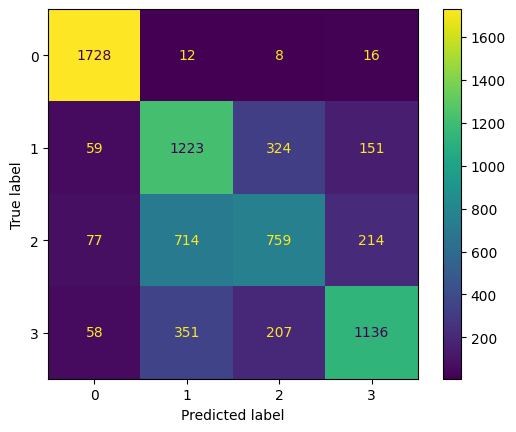

In [324]:
cm = confusion_matrix(y_test, y_pred, labels=xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb.classes_)
disp.plot()

plt.show()

In [344]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1764
           1       0.53      0.70      0.60      1757
           2       0.58      0.43      0.50      1764
           3       0.75      0.65      0.70      1752

    accuracy                           0.69      7037
   macro avg       0.69      0.69      0.68      7037
weighted avg       0.69      0.69      0.68      7037

